# Final Project Group 8

#### After a brief discussion, our group decided to select shopify app store data as our dataset. It contains the information about shopify app store apps (created by developers) and reviews (published by shops). It also reflects how online shop owners interact with apps and what features they need as well. In other words, the dataset can be used in multiple ways. From monitoring of the customer satisfaction index of existing apps to niche analysis before starting a new app.
#### For this dataset, We want to investigate if it has a large user group, what is the most frequently used apps and how price or other factors affect the users' evaluation of their experience with those apps. It’s our expectation to wrangle the data and document the dimension modeling to explore the more valuable insights based on this dataset. 

#### Memeber Linyu Wang, Hui Jing, Kai Ling and Xiang Fan participate equally in the project

In [1]:
## The ipython-sql library is loaded using the %load_ext iPython extension syntax and is pointed to the connection object 
%load_ext sql

In [2]:
## drop database in case it is already created. Ignore error "dbase_name does not exist"
!dropdb -U student FinalGP

In [3]:
## create a new database for user student and name it FinalGP
!createdb -U student FinalGP

In [4]:
## connect to the database. 
%sql postgresql://student@/FinalGP

'Connected: student@FinalGP'

In [5]:
## upload the our shopify dataset and rename it to shopify_app.zip
!wget "https://finalgp-istm6212.s3.amazonaws.com/shopify.zip"

--2019-12-02 00:49:02--  https://finalgp-istm6212.s3.amazonaws.com/shopify.zip
Resolving finalgp-istm6212.s3.amazonaws.com (finalgp-istm6212.s3.amazonaws.com)... 52.216.17.120
Connecting to finalgp-istm6212.s3.amazonaws.com (finalgp-istm6212.s3.amazonaws.com)|52.216.17.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5699368 (5.4M) [application/zip]
Saving to: ‘shopify.zip.9’

shopify.zip.9       100%[===================>]   5.43M  30.0MB/s    in 0.2s    

2019-12-02 00:49:02 (30.0 MB/s) - ‘shopify.zip.9’ saved [5699368/5699368]



In [6]:
## unzip the trips file for 4 quarters
!unzip -jo shopify.zip

Archive:  shopify.zip
  inflating: apps_categories.csv     
  inflating: ._apps_categories.csv   
  inflating: categories.csv          
  inflating: ._categories.csv        
  inflating: reviews.csv             
  inflating: ._reviews.csv           
  inflating: fact_table.csv          
  inflating: ._fact_table.csv        
  inflating: pricing_plans.csv       
  inflating: ._pricing_plans.csv     
  inflating: Time.csv                
  inflating: ._Time.csv              
  inflating: apps.csv                
  inflating: ._apps.csv              


## Data Preparation: Check the original rows in table app_categories,apps,categories,pricing_plans,reviews,Time file

#### Prepare spark

In [7]:
import findspark

In [8]:
findspark.init()

In [9]:
from pyspark import SparkContext

In [10]:
spark = SparkContext(appName='FinalGP')

In [11]:
spark

<SparkContext master=local[*] appName=FinalGP>

### apps file has 2831 records

In [12]:
apps = spark.textFile('apps.csv')

In [13]:
apps.count()

2832

### pricing_plan has 4928 records

In [12]:
pricing_plans = spark.textFile('pricing_plans.csv')

In [13]:
pricing_plans.count()

4929

### reviews has 292029 records

In [14]:
reviews = spark.textFile('reviews.csv')

In [15]:
reviews.count()

292030

### Time has 292029 records (comes from review table)

In [16]:
Time = spark.textFile('Time.csv')

In [17]:
Time.count()

292030

## Here is the schema

Let's have a quick look of original datasets

In [18]:
from IPython.display import Image

In [19]:
Image(url="https://finalgp-istm6212.s3.amazonaws.com/OriginalData.jpeg")

Here's the Wrangled Data we have

In [20]:
Image(url="https://finalgp-istm6212.s3.amazonaws.com/WrangledData.jpeg")

Here's the dimensional Table we create

In [21]:
Image(url="https://finalgp-istm6212.s3.amazonaws.com/DimensionalTable.jpeg")

## Prepare dimensional table for analysis

## Goal 1: App dimension table

### 1. Create app table

In [22]:
%%sql
DROP TABLE IF EXISTS app;

CREATE TABLE app (
    app_id              INTEGER NOT NULL,
    app_name            CHAR(100) NOT NULL,
    app_rating          NUMERIC NOT NULL,
    review_count        INTEGER NOT NULL,
    free_trial_days     INTEGER NOT NULL
);

 * postgresql://student@/FinalGP
Done.
Done.


[]

### 2. Import apps.csv data into app. 
It should have 2831 records

In [23]:
%%sql
COPY app FROM '/home/ubuntu/apps.csv'
CSV
HEADER;

 * postgresql://student@/FinalGP
2831 rows affected.


[]

### 3. Check 10 records in app table to see if it is consistent with what we want. 
It should have columns:app_id, app_name, app_rating, review_count, free_trial_days

In [24]:
%%sql
SELECT * FROM app
LIMIT 10

 * postgresql://student@/FinalGP
10 rows affected.


app_id,app_name,app_rating,review_count,free_trial_days
1,HitCounter,4.4,39,0
2,CategoriesUncomplicated,5,34,10
3,AdsbyVarinode,4.9,3336,0
4,AllinOneMetafields,4.9,11,7
5,ProductOptionsandCustomizer,4.3,70,10
6,SumAll,4.5,82,0
7,GetaQuote&HidePrices,4.8,17,7
8,One‑ClickCheckout,4.8,119,7
9,QuickViewandColorSwatches,4.8,8,14
10,InstantBrandPage,4.9,10,10


## Goal 2: Price_plan dimensional table which is based on the amount of different price plans

### 1. Create table price_plan_temp1 to maintain data from pricing_plan.

#### Step 1： Create table pricing_plan_temp1

In [25]:
%%sql
DROP TABLE IF EXISTS price_plan_temp1;

CREATE TABLE price_plan_temp1 (
    price_plan_id           INTEGER Not NULL, 
    app_id                    INTEGER NOT NULL,
    pricie_title             VARCHAR(50) NOT NULL,
    price                     NUMERIC NOT NULL,
    price_method            VARCHAR(30) NOT NULL   
);

 * postgresql://student@/FinalGP
Done.
Done.


[]

#### Step 2: Import data from pricing_plans.csv
It should contain 4928 records.

In [26]:
%%sql
COPY price_plan_temp1 FROM '/home/ubuntu/pricing_plans.csv'
CSV
HEADER;

 * postgresql://student@/FinalGP
4928 rows affected.


[]

### 2. Create table price_plan_temp2 to count the amount of pricing_plan (the count of "price") for each app.
data in price_plan_temp2 is based on the data in price_plan_temp1

#### Step 1: Create table price_plan_temp2
It should contain 2831 records since we did "Count" for the dataset

In [27]:
%%sql
DROP TABLE IF EXISTS price_plan_temp2;

CREATE TABLE price_plan_temp2 AS 
SELECT app_id, COUNT(price) AS pricing_choice, COUNT(price) AS price_plan_id
FROM price_plan_temp1
GROUP BY app_id
ORDER BY app_id

 * postgresql://student@/FinalGP
Done.
2831 rows affected.


[]

#### Step 2: Check 10 records in pricing_plan_temp2 to see if it is consistent with what we want. 
It should have columns: app_id,pricing_choice,price_plan_id

In [28]:
%%sql
SELECT * FROM price_plan_temp2
LIMIT 10

 * postgresql://student@/FinalGP
10 rows affected.


app_id,pricing_choice,price_plan_id
1,4,4
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1
10,1,1


#### We can see that overall we have 4 groups of pricing plan: 1 contains only 1 pricing choice,1 contains 2 pricing choices,1 contains 3 pricing choices and 1 contains 4 pricing choices.

In [29]:
%%sql
select distinct price_plan_id from price_plan_temp2

 * postgresql://student@/FinalGP
4 rows affected.


price_plan_id
4
1
3
2


### 3.Create price_plan table and insert data based on pricing_plan_temp2 table.

#### Step 1: Create pricing_plan table

In [30]:
%%sql
DROP TABLE IF EXISTS price_plan;

CREATE TABLE price_plan(
    key       INTEGER NOT NULL, 
    pricing_choice_amount  VARCHAR(200) NOT NULL,
    UNIQUE(key)
);

 * postgresql://student@/FinalGP
Done.
Done.


[]

#### Step 2: Insert data from pricing_plan_temp2

In [31]:
%%sql
INSERT INTO price_plan (key, pricing_choice_amount)
SELECT DISTINCT price_plan_id, pricing_choice
FROM price_plan_temp2
ORDER BY price_plan_id

 * postgresql://student@/FinalGP
4 rows affected.


[]

#### Step3: Check data in pricing_plan dimension table

In [32]:
%%sql
SELECT * FROM price_plan

 * postgresql://student@/FinalGP
4 rows affected.


key,pricing_choice_amount
1,1
2,2
3,3
4,4


## Goal 3: Time dimensional table

### 1. Create time dimensional table

In [33]:
%%sql
DROP TABLE IF EXISTS time;

CREATE TABLE time (
    key            SERIAL PRIMARY KEY,
    post_time      CHAR(20) NOT NULL,
    month_abb      CHAR(3) NOT NULL,
    week_day       INTEGER NOT NULL,
    day_of_month   INTEGER NOT NULL,
    month_of_year  INTEGER NOT NULL,
    year           INTEGER NOT NULL
);

 * postgresql://student@/FinalGP
Done.
Done.


[]

### 2. Prepare data for time dimensional table

#### Step 1: Create a time_temp table

In [34]:
%%sql
DROP TABLE IF EXISTS time_temp;

CREATE TABLE time_temp (
    post_time      CHAR(20) NOT NULL,
    month_abb      CHAR(3) NOT NULL,
    week_day       INTEGER NOT NULL,
    day_of_month   INTEGER NOT NULL,
    month_of_year  INTEGER NOT NULL,
    year           INTEGER NOT NULL
);

 * postgresql://student@/FinalGP
Done.
Done.


[]

#### Step 2: Import Time.csv into time_temp table
It should have 292029 records.

In [35]:
%%sql
COPY time_temp
FROM '/home/ubuntu/Time.csv'
CSV
HEADER;

 * postgresql://student@/FinalGP
292029 rows affected.


[]

### 3. Import data from time_temp to time
It should contain 2748 records since we only want to have distinct time information

In [36]:
%%sql
INSERT INTO time(post_time ,month_abb, week_day,day_of_month, month_of_year, year)
SELECT DISTINCT post_time ,month_abb, week_day,day_of_month, month_of_year, year
FROM time_temp

 * postgresql://student@/FinalGP
2748 rows affected.


[]

#### Here's a quick look of time dimension table

In [37]:
%%sql
SELECT * FROM time
LIMIT 10

 * postgresql://student@/FinalGP
10 rows affected.


key,post_time,month_abb,week_day,day_of_month,month_of_year,year
1,17-Aug-14,Aug,7,17,8,2014
2,26-Feb-15,Feb,4,26,2,2015
3,1-Dec-16,Dec,4,1,12,2016
4,24-Feb-13,Feb,7,24,2,2013
5,28-Sep-16,Sep,3,28,9,2016
6,20-Oct-13,Oct,7,20,10,2013
7,26-May-18,May,6,26,5,2018
8,5-Jan-18,Jan,5,5,1,2018
9,6-May-13,May,1,6,5,2013
10,8-Nov-16,Nov,2,8,11,2016


## Goal 4: rating fact table

### 1. Create rating table

In [38]:
%%sql 
DROP TABLE IF EXISTS rating;

CREATE TABLE rating(
    app_key            INTEGER NOT NULL,
    author            VARCHAR(500) NOT NULL,
    rating            INTEGER NOT NULL,
    post_time         CHAR(20) NOT NULL,
    month_abb         CHAR(3) NOT NULL,
    week_day          INTEGER NOT NULL,
    day_of_month      INTEGER NOT NULL,
    month_of_year     INTEGER NOT NULL,
    year              INTEGER NOT NULL
);

 * postgresql://student@/FinalGP
Done.
Done.


[]

### 2. Import reviews.csv into rating table
It should contain 292029 records.

In [39]:
%%sql
COPY rating FROM '/home/ubuntu/reviews.csv'
CSV
HEADER;

 * postgresql://student@/FinalGP
292029 rows affected.


[]

### 3. Add time_key into rating table

In [40]:
%%sql
ALTER TABLE rating
ADD COLUMN time_key INTEGER,
ADD CONSTRAINT fk_time_key
    FOREIGN KEY (time_key)
    REFERENCES time (key);

UPDATE rating
SET time_key = time.key
FROM time
WHERE rating.post_time = time.post_time;

 * postgresql://student@/FinalGP
Done.
292029 rows affected.


[]

### 4. Add price_plan_key into rating table

In [41]:
%%sql
ALTER TABLE rating
ADD COLUMN price_plan_key INTEGER,
ADD CONSTRAINT fk_price_plan_key
    FOREIGN KEY (price_plan_key)
    REFERENCES price_plan (key);
    
UPDATE rating
SET price_plan_key = price_plan_temp2.price_plan_id
FROM price_plan_temp2
WHERE price_plan_temp2.app_id = rating.app_key;

 * postgresql://student@/FinalGP
Done.
292029 rows affected.


[]

### 5. Remove unnecessary column from rating table

In [42]:
%%sql
ALTER TABLE rating
DROP COLUMN post_time,
DROP COLUMN month_abb,
DROP COLUMN week_day,
DROP COLUMN day_of_month,
DROP COLUMN month_of_year,
DROP COLUMN year;

 * postgresql://student@/FinalGP
Done.


[]

#### Check the final rating table
It should contain columns: app_key, author, rating, time_key, price_plan_key

In [43]:
%%sql
SELECT * FROM rating
ORDER BY app_key
LIMIT 10

 * postgresql://student@/FinalGP
10 rows affected.


app_key,author,rating,time_key,price_plan_key
1,Simply Beautiful,5,670,4
1,Antler & Bone,4,1360,4
1,presetcabana,5,2207,4
1,Batik 2.0,5,1869,4
1,Style Art Villa,4,1364,4
1,Rich Frames,4,1850,4
1,Zollpa,5,2367,4
1,Best Buys Shop Here,5,2207,4
1,AyurAlpha,4,312,4
1,Custom Curves,5,1891,4


### Business Question 1: Find the top 10 apps with most rating records.

In [44]:
%%sql
SELECT DISTINCT rating.app_key AS appid, app.app_name AS name, COUNT(rating.rating) AS count
FROM rating JOIN app
ON rating.app_key = app.app_id
GROUP BY appid, name
ORDER BY count DESC
LIMIT 10;

 * postgresql://student@/FinalGP
10 rows affected.


appid,name,count
595,Privy‑ExitPopUps&Email,20517
570,FreeShippingBarbyHextom,8220
780,RecartFBMessengerMarketing,5553
427,BESTCurrencyConverter,5119
1072,EUCookieBar‑CookieGDPR,4534
2457,SalesPop‑SalesNotification,4105
2313,QuickAnnouncementBar,3862
652,UltimateSalesBoost,3773
3,AdsbyVarinode,3336
448,SmileRewards&Loyalty,3241


In [45]:
%matplotlib inline

<BarContainer object of 10 artists>

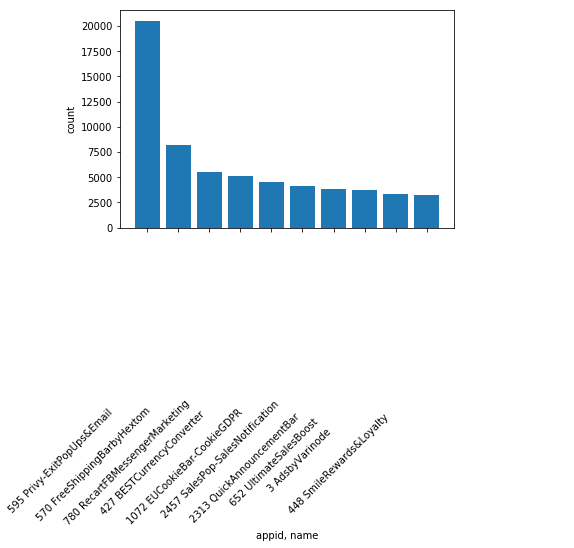

In [46]:
_.bar()

### Business Question 2: Investigate the relationship between review count and rating level.

##### Count the review count of the same app_id and average the rating according to app_id. We can see that rating 5 star and rating 1 star has the highest review counts which means customers who appricate specific apps and cutomers who complain about specific apps are willing to post their using experience.

In [47]:
%%sql
CREATE VIEW review_count_view AS
SELECT app.app_id,AVG(rating.rating) AS rating_avg1,COUNT(app.review_count) AS review_count1
FROM app JOIN rating
ON app.app_id = rating.app_key
GROUP BY app.app_id,app.review_count

 * postgresql://student@/FinalGP
Done.


[]

#### count the number of review_count of the same rating_average

##### show from the largest count number and show the graph

In [48]:
%%sql
SELECT cast (review_count_view.rating_avg1 as decimal(10,3)), COUNT(review_count1)
FROM review_count_view
GROUP BY review_count_view.rating_avg1
ORDER BY count DESC
LIMIT 15;

 * postgresql://student@/FinalGP
15 rows affected.


rating_avg1,count
5.000,676
4.000,70
1.000,64
3.000,61
4.500,40
3.667,36
4.750,28
4.333,25
4.667,23
4.200,21


In [49]:
%matplotlib inline

<BarContainer object of 15 artists>

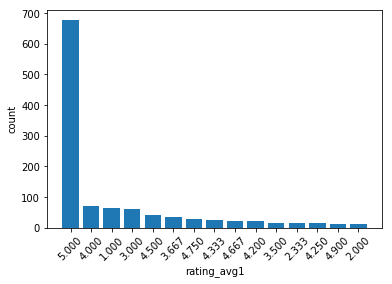

In [50]:
_.bar()

#####  show from the smallest count number and show the graph

In [51]:
%%sql
SELECT cast (review_count_view.rating_avg1 as decimal(10,3)), COUNT(review_count1)
FROM review_count_view
GROUP BY review_count_view.rating_avg1
LIMIT 15;

 * postgresql://student@/FinalGP
15 rows affected.


rating_avg1,count
1.000,64
1.333,2
1.500,1
1.665,1
1.667,3
1.697,1
1.786,1
1.805,1
1.817,1
2.000,12


In [52]:
%matplotlib inline

<BarContainer object of 15 artists>

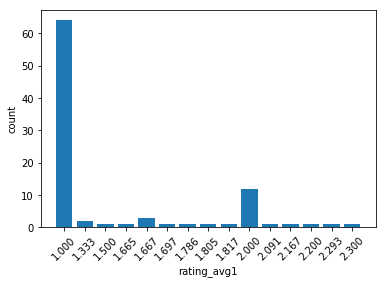

In [53]:
_.bar()

### Business Question 3: The relationship between time and rating

##### We found customers are not willing to leave comments on weekends (Saturday and Sunday) comparing to on weekdays.  

In [54]:
%%sql
SELECT DISTINCT time.week_day, COUNT(rating.rating)
FROM time JOIN rating
ON time.key = rating.time_key
GROUP BY time.week_day
ORDER BY count

 * postgresql://student@/FinalGP
7 rows affected.


week_day,count
6,29427
7,29812
5,42148
1,45470
2,47938
4,48253
3,48981


In [55]:
%matplotlib inline

<BarContainer object of 7 artists>

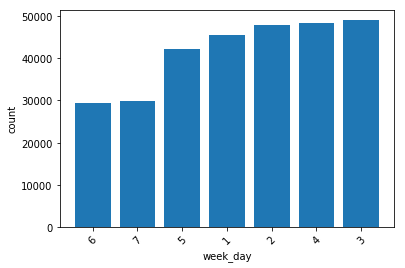

In [56]:
_.bar()

### Business Question 4: The relationship between price plan and rating

### From rating table we can see price_plan 1 has the most comments.

In [57]:
%%sql
SELECT price_plan_key,count(price_plan_key)
FROM rating
group by price_plan_key

 * postgresql://student@/FinalGP
4 rows affected.


price_plan_key,count
4,78332
1,117754
3,42065
2,53878


In [58]:
%matplotlib inline

<BarContainer object of 4 artists>

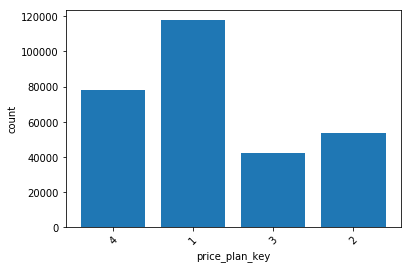

In [59]:
_.bar()

### We can see that plan 1 has a large amount of 5 star evaluation so this plan is the most widely used plan as well as most succesuful plan.

In [60]:
%%sql
SELECT count(price_plan_key),rating
FROM rating
where price_plan_key=1
group by rating
order by rating

 * postgresql://student@/FinalGP
5 rows affected.


count,rating
5863,1
1468,2
2613,3
9203,4
98607,5


In [61]:
%matplotlib inline

<BarContainer object of 5 artists>

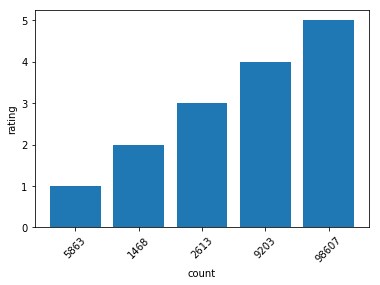

In [62]:
_.bar()